In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset
import mido

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True

print(device)

cuda:0


In [3]:
trainData = np.load('npy_data/NPYData.npy')
#trainData = np.load('DataByCompos/Beethoven/npy/NPYData.npy')

In [4]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size)).to(device)

In [5]:
def randomTrainingExample():
    #line = trainData[random.randint(0, len(trainData) - 1)]
    #input_line_tensor = inputTensor(line)
    #target_line_tensor = targetTensor(line)
    i = random.randint(0, len(trainData) - 1)
    LEN = min(len(trainData[i]), 1600)
    r = random.randint(0, len(trainData[i]) - LEN - 2)
    if (LEN < 1600):
        r = 0
    line = trainData[i][r:r+LEN]
    #inputs = inputTensor(line)
    #targets = targetTensor(line)
    inputs = Variable(torch.from_numpy(np.asarray(trainData[i][r:r+LEN])).long())
    targets = Variable(torch.from_numpy(np.asarray(trainData[i][r+1:r+LEN+1])).long())
    #targets = torch.LongTensor(trainData[i][r:r+LEN])
    return inputs.to(device), targets.to(device)

In [6]:
criterion = nn.CrossEntropyLoss()

def train(input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.init_hidden()

    rnn.zero_grad()
    
    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(input_line_tensor[i], hidden)
        #print(output)
        #print(target_line_tensor[i])
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    optimizer.step()

    return output, loss.item() / input_line_tensor.size(0)

In [7]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [9]:
rnn = RNN(416, 1500, 416, 3).to(device)

In [10]:
all_losses = []

In [11]:
n_iters = 8000
print_every = 10
plot_every = 5
total_loss = 0

optimizer = optim.Adam(rnn.parameters(), lr=0.005)

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    #print(output)
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

1m 5s (10 0%) 7.1341
2m 9s (20 0%) 6.1037
3m 11s (30 0%) 5.3698
4m 14s (40 0%) 5.3629
5m 16s (50 0%) 4.3586
6m 18s (60 0%) 4.9785
7m 19s (70 0%) 4.9827
8m 20s (80 1%) 4.3630
9m 22s (90 1%) 4.7692
10m 24s (100 1%) 4.8623
11m 27s (110 1%) 4.0855
12m 29s (120 1%) 5.4567
13m 32s (130 1%) 4.5371
14m 37s (140 1%) 4.7852
15m 39s (150 1%) 5.0327
16m 41s (160 2%) 4.4838
17m 43s (170 2%) 4.1760
18m 45s (180 2%) 4.7280
19m 47s (190 2%) 4.6893
20m 49s (200 2%) 4.1968
21m 51s (210 2%) 5.0331
22m 54s (220 2%) 4.5700
23m 56s (230 2%) 5.3537
24m 59s (240 3%) 5.5941
26m 1s (250 3%) 4.4099
27m 4s (260 3%) 5.0143
28m 6s (270 3%) 4.3185
29m 8s (280 3%) 4.1406
30m 10s (290 3%) 4.0724
31m 13s (300 3%) 4.7669
32m 19s (310 3%) 4.5748
33m 25s (320 4%) 4.1806
34m 33s (330 4%) 4.6233
35m 37s (340 4%) 4.4269
36m 41s (350 4%) 3.7163
37m 46s (360 4%) 3.6818
38m 52s (370 4%) 3.8266
39m 59s (380 4%) 3.9247
41m 4s (390 4%) 3.6685
42m 8s (400 5%) 3.3127
43m 15s (410 5%) 4.0859
44m 22s (420 5%) 4.0759
45m 27s (430 5%) 3

305m 24s (3180 39%) 3.8644
306m 20s (3190 39%) 3.9475
307m 17s (3200 40%) 3.5523
308m 13s (3210 40%) 4.2563
309m 10s (3220 40%) 3.7899
310m 7s (3230 40%) 3.8189
311m 4s (3240 40%) 3.7952
312m 1s (3250 40%) 3.5858
312m 57s (3260 40%) 3.9139
313m 54s (3270 40%) 3.7307
314m 50s (3280 41%) 4.1078
315m 47s (3290 41%) 3.3573
316m 43s (3300 41%) 4.1073
317m 40s (3310 41%) 4.0232
318m 37s (3320 41%) 4.6208
319m 33s (3330 41%) 3.3276
320m 30s (3340 41%) 3.5964
321m 26s (3350 41%) 3.7337
322m 23s (3360 42%) 4.2626
323m 20s (3370 42%) 4.2031
324m 17s (3380 42%) 4.9883
325m 13s (3390 42%) 3.7928
326m 10s (3400 42%) 3.6080
327m 6s (3410 42%) 3.8808
328m 3s (3420 42%) 3.8708
329m 0s (3430 42%) 4.1757
329m 58s (3440 43%) 3.5042
330m 54s (3450 43%) 3.7210
331m 51s (3460 43%) 3.7896
332m 48s (3470 43%) 3.7538
333m 45s (3480 43%) 3.6349
334m 42s (3490 43%) 3.7706
335m 38s (3500 43%) 3.4856
336m 35s (3510 43%) 3.7826
337m 32s (3520 44%) 3.6829
338m 28s (3530 44%) 3.6908
339m 25s (3540 44%) 3.8322
340m 21

KeyboardInterrupt: 

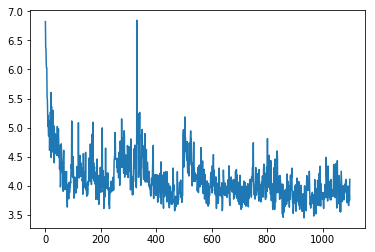

In [12]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.show()

In [13]:
torch.save(rnn.state_dict(), 'models\model_523m.pt')

In [14]:
def evaluate(prime_str=[15], predict_len=100, temperature=0.8):
    hidden = rnn.init_hidden()
    prime_input = Variable(torch.from_numpy(np.asarray(prime_str)).long()).to(device)
    predicted = prime_str

    for p in range(len(prime_str) - 1):
        _, hidden = rnn(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = rnn(inp, hidden)

        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = int(torch.multinomial(output_dist, 1)[0])

        predicted.append(top_i)
        inp = Variable(torch.from_numpy(np.asarray([top_i])).long()).to(device)

    return predicted

In [15]:
evDict = {}
evDictBack = {}
c = 1;
for i in range(0, 33):
    evDict['set_velocity ' + str(i)] = c
    evDictBack[c] = 'set_velocity ' + str(i)
    c += 1
for i in range(1, 129):
    evDict['note_on ' + str(i)] = c
    evDictBack[c] = 'note_on ' + str(i)
    c += 1
for i in range(1, 129):
    evDict['note_off ' + str(i)] = c
    evDictBack[c] = 'note_off ' + str(i)
    c += 1
for i in range(0, 126):
    evDict['time_shift ' + str(i)] = c
    evDictBack[c] = 'time_shift ' + str(i)
    c += 1
print(c)

416


In [18]:
for i in range(1, 6):
    song = evaluate([random.randint(1, 400)], 1000, 0.6)
    mid = mido.MidiFile()
    track = mido.MidiTrack()
    mid.tracks.append(track)
    vel = 0
    note = 0
    m = ""
    for t in song:
        tmp = evDictBack[t]
        mode, c = tmp.split()
        if mode == "note_on" or mode == "note_off":
            note = int(c)
            m = mode       
        elif mode == "set_velocity":
            vel = int(c)*4
            if vel == 128:
                vel = 127
        elif mode == "time_shift" and m == "note_on" or m == "note_off":
            tm = int(mido.second2tick(int(c)*8*4/1000, 384, 512820))
            track.append(mido.Message(m, note=note, velocity=vel, time=tm))
    name = 'output/Song' + str(i) + '.mid'
    mid.save(name)